In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV, GroupKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import make_classification
from sklearn.inspection import permutation_importance
from sklearn.base import BaseEstimator, ClassifierMixin

import torch
import torch.nn as nn
import torch.optim as optim


import lightgbm as lgb
import glob
from tqdm import tqdm
import yaml

from feature_engineering import make_data
from feature_engineering import get_data
from autoencoder import Autoencoder
import data

In [2]:
path = ["../data/O013257.npz", "../data/O013490.npz", "../data/O012791.npz"]
cv_path = ["../data/O013257.npz", "../data/O013490.npz"]
test_path = ["../data/O012791.npz"]

In [3]:
cv_new = get_data(cv_path)
test_new = get_data(test_path)

done reshaping images
working on image 0
done reshaping images
working on image 0


In [4]:
config_path = "configs/layer10_batch_size1028.yaml"
checkpoint_path = "results/layer10_batch_size1028-epoch=024.ckpt"

config = yaml.safe_load(open(config_path, "r"))

# initialize the autoencoder class
model = Autoencoder(patch_size=config["data"]["patch_size"], **config["autoencoder"])
# tell PyTorch to load the model onto the CPU if no GPU is available
map_location = None if torch.cuda.is_available() else 'cpu'
# load checkpoint
checkpoint = torch.load(checkpoint_path, map_location=map_location)
# load the checkpoint's state_dict into the model
model.load_state_dict(checkpoint["state_dict"])

<All keys matched successfully>

In [6]:
# Get embedding features from autoencoder
# only get patches for the three labeled images

file_names = ["O013257_ae", "O013490_ae", "O012791_ae"]

# only get patches for the three labeled images
images_long, patches = data.make_data(patch_size=9)

print("Obtaining embeddings")
# get the embedding for each patch
embeddings = []  # what we will save

for i in tqdm(range(len(images_long))):
    ys = images_long[i][:, 0]
    xs = images_long[i][:, 1]

    # determine the height and width of the image
    miny = min(ys)
    minx = min(xs)
    height = int(max(ys) - miny + 1)
    width = int(max(xs) - minx + 1)

    # to make this faster, we use torch.no_grad() to disable gradient tracking
    with torch.no_grad():
        # get the embedding of array of patches
        emb = model.embed(torch.tensor(np.array(patches[i])))
        # in the following line we:
        # - detach the tensor from the computation graph
        # - move it to the cpu
        # - turn it into a numpy array
        emb = emb.detach().cpu().numpy()

    embeddings.append(emb)

    # represent the embedding as an image, if you want
    img_embedded = np.zeros((emb.shape[1], height, width))
    img_embedded[:, (ys - miny).astype(int), (xs - minx).astype(int)] = emb.T

print("Saving the embeddings")
# save the embeddings as csv
for i in tqdm(range(len(images_long))):
    embedding_df = pd.DataFrame(embeddings[i], columns=[f"ae{i}" for i in range(50)])
    embedding_df["y"] = images_long[i][:, 0]
    embedding_df["x"] = images_long[i][:, 1]
    # move y and x to front
    cols = embedding_df.columns.tolist()
    cols = cols[-2:] + cols[:-2]
    embedding_df = embedding_df[cols]
    file = file_names[i]
    # save to csv
    embedding_df.to_csv(f"../data/{file}.csv", index=False)

done reshaping images
working on image 0
Obtaining embeddings


100%|██████████| 3/3 [00:31<00:00, 10.49s/it]


Saving the embeddings


100%|██████████| 3/3 [00:17<00:00,  5.67s/it]


In [5]:
# Get final data ready for prediction

# Read all three CSV files
df1 = pd.read_csv('../data/O013257_ae.csv')
df2 = pd.read_csv('../data/O013490_ae.csv')
df3 = pd.read_csv('../data/O012791_ae.csv')

In [6]:
# Concatenate all dataframes vertically (stacking them on top of each other)
cv_ae_df = pd.concat([df1, df2], axis=0, ignore_index=True)
test_ae_df = pd.concat([df3], axis=0, ignore_index=True)

# Reset index for both dataframes to ensure they align properly
cv_ae_df.reset_index(drop=True, inplace=True)
test_ae_df.reset_index(drop=True, inplace=True)
cv_new.reset_index(drop=True, inplace=True)
test_new.reset_index(drop=True, inplace=True)

# Combine all columns from both dataframes
cv_final_df = pd.concat([cv_ae_df, cv_new.drop(['x', 'y'], axis=1)], axis=1)
test_final_df = pd.concat([test_ae_df, test_new.drop(['x', 'y'], axis=1)], axis=1)

In [7]:
# Load separate training and test sets
train_val_df = cv_final_df
test_df = test_final_df

In [8]:
def assign_quadrants(df):
    """
    Assigns a quadrant label to each row in the DataFrame based on the median of x and y coordinates.

    This function computes the overall medians of the 'x' and 'y' coordinates in the input DataFrame
    and assigns each row to one of four quadrants:

    Args:
        df (pd.DataFrame): A DataFrame containing 'x' and 'y' columns representing spatial coordinates.

    Returns:
        pd.Series: A Pandas Series with quadrant labels ('Q1', 'Q2', 'Q3', 'Q4') for each row.
    """

    # Compute overall medians for x and y
    median_x = df['x'].median()
    median_y = df['y'].median()
    
    # Assign quadrant based on overall medians
    def get_q(row):
        if row['x'] <= median_x and row['y'] <= median_y:
            return 'Q1'
        elif row['x'] > median_x and row['y'] <= median_y:
            return 'Q2'
        elif row['x'] <= median_x and row['y'] > median_y:
            return 'Q3'
        else:
            return 'Q4'
    
    df['quadrant'] = df.apply(get_q, axis=1)
    return df

# Simplified data processing
train_val_df = assign_quadrants(train_val_df)
train_val_df_filtered = train_val_df[train_val_df['expert_label'] != 0]
test_df_filtered = test_df[test_df['expert_label'] != 0]  

train_val_df = train_val_df.drop(columns=["y", "x"])
test_df = test_df.drop(columns=["y", "x"])

In [9]:
# Separate features and target
feature_columns = train_val_df.columns.drop(['expert_label', 'quadrant'])
X_train = train_val_df_filtered[feature_columns]
y_train = train_val_df_filtered['expert_label'].astype(int) 
X_test = test_df_filtered[feature_columns]  
y_test = test_df_filtered['expert_label'].astype(int) 

Random Forest Classifer

In [10]:
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupKFold, cross_val_score
from sklearn.metrics import accuracy_score

# Function to optimize the hyperparameters using Optuna
def objective(trial):
    # Suggest hyperparameters for RandomForest
    n_estimators = trial.suggest_int('n_estimators', 20, 100)
    max_depth = trial.suggest_int('max_depth', 10, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 4)
    class_weight = trial.suggest_categorical('class_weight', ['balanced', 'balanced_subsample', None])

    # Initialize the RandomForestClassifier with the hyperparameters
    rf_clf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        class_weight=class_weight,
        random_state=42
    )

    # Set up GroupKFold cross-validation
    group_kfold = GroupKFold(n_splits=len(train_val_df_filtered['quadrant'].unique()))
    groups = train_val_df_filtered['quadrant']

    # Cross-validation (use accuracy as the evaluation metric)
    score = cross_val_score(
        rf_clf,
        X_train,  # Use the X_train features
        y_train,  # Use the y_train target
        cv=group_kfold,
        scoring='accuracy',
        n_jobs=-1,
        groups=groups
    ).mean()

    return score  # Return the mean accuracy

# Define the study for hyperparameter optimization
study = optuna.create_study(direction='maximize')  # We want to maximize the accuracy
study.optimize(objective, n_trials=10)  # Run 50 trials

# Get the best parameters and best score
best_params = study.best_params
best_score = study.best_value

print(f"Best hyperparameters: {best_params}")
print(f"Best accuracy: {best_score}")

# After optimization, you can retrain your model on the full training data using the best parameters:
best_rf_clf = RandomForestClassifier(
    **best_params, 
    random_state=42
)

# Fit the model with the best hyperparameters
best_rf_clf.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred = best_rf_clf.predict(X_test)

# Evaluate performance (accuracy as an example)
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test accuracy with best hyperparameters: {test_accuracy}")


/jet/home/rliu12/.conda/envs/env_214/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-03-21 23:56:48,649] A new study created in memory with name: no-name-95d40c8e-10c4-4c0d-8c21-ef5d6995659d
[I 2025-03-21 23:59:18,434] Trial 0 finished with value: 0.9494158083770861 and parameters: {'n_estimators': 93, 'max_depth': 36, 'min_samples_split': 6, 'min_samples_leaf': 3, 'class_weight': 'balanced_subsample'}. Best is trial 0 with value: 0.9494158083770861.
[I 2025-03-22 00:00:17,267] Trial 1 finished with value: 0.9554167188667442 and parameters: {'n_estimators': 42, 'max_depth': 48, 'min_samples_split': 10, 'min_samples_leaf': 4, 'class_weight': None}. Best is trial 1 with value: 0.9554167188667442.
[I 2025-03-22 00:02:22,617] Trial 2 finished with value: 0.9511808171859258 and parameters: {'n_estima

Best hyperparameters: {'n_estimators': 82, 'max_depth': 11, 'min_samples_split': 10, 'min_samples_leaf': 1, 'class_weight': None}
Best accuracy: 0.9627887025970577
Test accuracy with best hyperparameters: 0.817205871613233



Classification Report:
              precision    recall  f1-score   support

          -1       0.83      0.88      0.85     33528
           1       0.79      0.72      0.75     21244

    accuracy                           0.82     54772
   macro avg       0.81      0.80      0.80     54772
weighted avg       0.82      0.82      0.82     54772



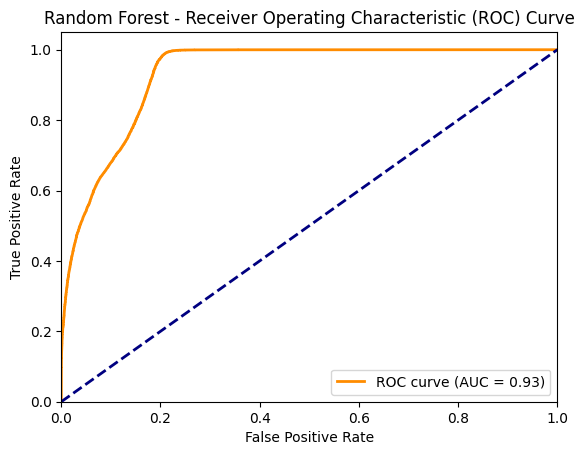

In [11]:
rf_conf_matrix = confusion_matrix(y_test, y_pred)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Calculate and plot ROC curve
rf_proba = best_rf_clf.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, rf_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest - Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

K-Nearest Neighbors

Fitting 4 folds for each of 4 candidates, totalling 16 fits
Best Parameters: {'n_neighbors': 4}
Best Score: 0.931493218689671

Classification Report:
              precision    recall  f1-score   support

        -1.0       0.82      0.91      0.86     33528
         1.0       0.82      0.68      0.74     21244

    accuracy                           0.82     54772
   macro avg       0.82      0.79      0.80     54772
weighted avg       0.82      0.82      0.81     54772



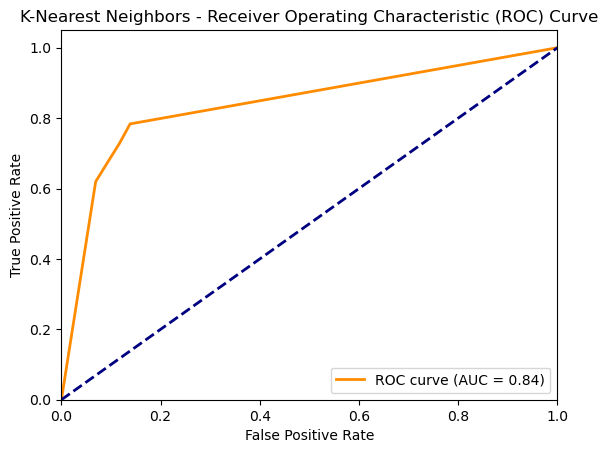

In [ ]:
# Scale the features
feature_scaler = StandardScaler()
training_data_norm = pd.DataFrame(feature_scaler.fit_transform(X_train), columns=X_train.columns)
testing_data_norm = pd.DataFrame(feature_scaler.transform(X_test), columns=X_test.columns)

# Initialize KNN classifier with expanded parameters
neighbor_clf = KNeighborsClassifier()
neighbor_params = {
    'n_neighbors': [1, 2, 3, 4]  # odd numbers to avoid ties
}

# Set up cross-validation with GroupKFold
spatial_groups = train_val_df_filtered['quadrant']
group_kfold = GroupKFold(n_splits=len(train_val_df_filtered['quadrant'].unique()))

# Perform grid search with scoring metric
param_search = GridSearchCV(
    estimator=neighbor_clf,
    param_grid=neighbor_params,
    cv=group_kfold,
    scoring='accuracy', 
    n_jobs=-1,
    verbose=1
)

# Fit the model
param_search.fit(training_data_norm, y_train, groups=spatial_groups)

print("Best Parameters:", param_search.best_params_)
print("Best Score:", param_search.best_score_)

# Get predictions using best model
optimal_neighbor_clf = param_search.best_estimator_
neighbor_predictions = optimal_neighbor_clf.predict(testing_data_norm)
neighbor_conf_matrix = confusion_matrix(y_test, neighbor_predictions)

# Print detailed performance metrics
print("\nClassification Report:")
print(classification_report(y_test, neighbor_predictions))

# Calculate and plot ROC curve
neighbor_proba = optimal_neighbor_clf.predict_proba(testing_data_norm)[:, 1]
fpr, tpr, _ = roc_curve(y_test, neighbor_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('K-Nearest Neighbors - Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

LightGBM

Fitting 4 folds for each of 32 candidates, totalling 128 fits
[LightGBM] [Info] Number of positive: 56099, number of negative: 59437
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037612 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 22950
[LightGBM] [Info] Number of data points in the train set: 115536, number of used features: 90
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.485554 -> initscore=-0.057799
[LightGBM] [Info] Start training from score -0.057799
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Li

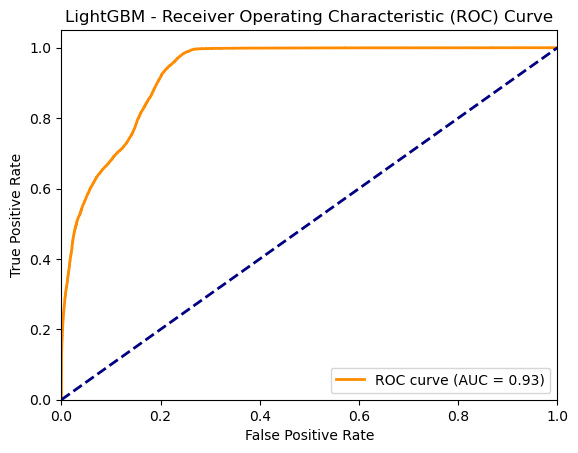


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

In [ ]:
# Define parameter grid for LightGBM
lgb_params = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [5, 7],
    'num_leaves': [31, 63],
    'min_child_samples': [20, 50]
}

# Initialize LightGBM classifier
lgb_clf = lgb.LGBMClassifier(random_state=42)

# Set up GroupKFold cross-validation
groups = train_val_df_filtered['quadrant']
group_kfold = GroupKFold(n_splits=len(train_val_df_filtered['quadrant'].unique()))

# Perform grid search
lgb_search = GridSearchCV(
    estimator=lgb_clf,
    param_grid=lgb_params,
    cv=group_kfold,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Fit the model
lgb_search.fit(X_train, y_train, groups=groups)

# Print best parameters and score
print("Best Parameters:", lgb_search.best_params_)
print("Best Score:", lgb_search.best_score_)

# Get predictions using best model
best_lgb = lgb_search.best_estimator_
lgb_predictions = best_lgb.predict(X_test)
lgb_conf_matrix = confusion_matrix(y_test, lgb_predictions)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, lgb_predictions))

# Calculate and plot ROC curve
lgb_proba = best_lgb.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, lgb_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('LightGBM - Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()